This is for the autoencoder model.In this model we are using the autoencoder model to reduce the dimensions of the data.And then this is used to convert back to the original input.

In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam

In [22]:
df = pd.read_csv('SAML-D_cleaned_final.csv')

<ipython-input-22-434d0fa35970>:1: DtypeWarning: Columns (47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('SAML-D_cleaned_final.csv')


For the model use drop unnamed and risk score features from the data.

In [23]:
df=df.drop(columns=['Unnamed: 0','risk_score'])

In [24]:
# Identify boolean columns and convert them to integers
bool_columns = df.select_dtypes(include=['bool', 'object']).columns

for col in bool_columns:
    # Convert boolean-like object columns to actual boolean type first
    if df[col].dtype == 'object':
        df[col] = df[col].map({'True': True, 'False': False, 'true': True, 'false': False})

    # Replace NaN values with a default value (e.g., False or 0)
    df[col].fillna(False, inplace=True)

    # Convert boolean columns to integers
    df[col] = df[col].astype(int)

In [25]:
df.head()

,Sender_account,Receiver_account,Amount,Year,Month,Day,Hour,Minute,Second,Payment_currency_Albanian lek,...,Laundering_type_Normal_Plus_Mutual,Laundering_type_Normal_Small_Fan_Out,Laundering_type_Normal_single_large,Laundering_type_Scatter-Gather,Laundering_type_Single_large,Laundering_type_Smurfing,Laundering_type_Stacked Bipartite,Laundering_type_Structuring,Is_Laundering,high_risk_countries
0,4248061080,9527052910,13480.74,2023,8,14,2,8,46,0,...,0,0,0,0,0,0,0,0,0.0,0.0
1,9130896737,908371799,10480.05,2023,7,2,19,48,23,0,...,0,0,0,0,0,0,0,0,0.0,0.0
2,1466348255,8545558838,26232.35,2023,7,22,12,4,24,0,...,0,0,0,0,0,0,0,0,0.0,0.0
3,2181923623,6234034932,447.07,2022,10,28,17,8,2,0,...,0,0,0,0,0,0,0,0,0.0,0.0
4,8596132461,3638213339,1005.62,2023,2,21,22,44,17,0,...,0,0,0,0,0,0,0,0,0.0,0.0


In [26]:
df.dtypes

Sender_account                         int64
Receiver_account                       int64
Amount                               float64
Year                                   int64
Month                                  int64
                                      ...   
Laundering_type_Smurfing               int64
Laundering_type_Stacked Bipartite      int64
Laundering_type_Structuring            int64
Is_Laundering                        float64
high_risk_countries                  float64
Length: 107, dtype: object

In [27]:
if df.isnull().values.any():
    df = df.dropna()

In [28]:
#Selecting the X as everything except the target
X = df.drop(columns=['Is_Laundering'])
y = df['Is_Laundering']

THis is the start of the auto encode codes.

In [29]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
if np.isnan(X_scaled).any() or np.isinf(X_scaled).any():
    print("Scaled data contains NaN or Infinite values")

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

We derive the functionality to a factor of 8.

In [32]:
input_dim = X_train.shape[1]
encoding_dim = 8

In [33]:
input_layer = Input(shape=(input_dim,))

In [34]:
encoder = Dense(64, activation='relu', kernel_initializer='he_normal')(input_layer)
encoder = Dense(32, activation='relu', kernel_initializer='he_normal')(encoder)
encoded = Dense(encoding_dim, activation='relu', kernel_initializer='he_normal')(encoder)

In [35]:
decoder = Dense(32, activation='relu', kernel_initializer='he_normal')(encoded)
decoder = Dense(64, activation='relu', kernel_initializer='he_normal')(decoder)
decoded = Dense(input_dim, activation='sigmoid')(decoder)

In [36]:
autoencoder = Model(inputs=input_layer, outputs=decoded)

In [37]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 106)]             0         
                                                                 
 dense (Dense)               (None, 64)                6848      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 32)                288       
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 106)               6890  

In [38]:
optimizer = Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

In [41]:
history=autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/50
177/177 [==============================] - 1s 6ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 2/50
177/177 [==============================] - 1s 6ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/50
177/177 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/50
177/177 [==============================] - 1s 4ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/50
177/177 [==============================] - 1s 4ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/50
177/177 [==============================] - 1s 4ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/50
177/177 [==============================] - 1s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/50
177/177 [==============================] - 1s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/50
177/177 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/50
177/177 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0012

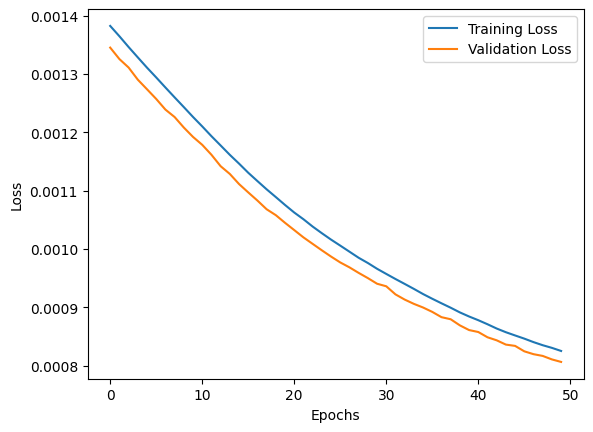

In [42]:
# Visualize the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
encoder_model = Model(inputs=input_layer, outputs=encoded)

In [44]:
encoded_data = encoder_model.predict(X_scaled)

1769/1769 [==============================] - 3s 1ms/step


In [45]:
if np.isnan(encoded_data).any() or np.isinf(encoded_data).any():
    print("Encoded data contains NaN or Infinite values")

In [46]:
encoded_features_df = pd.DataFrame(encoded_data, columns=[f'Encoded_Feature_{i+1}' for i in range(encoding_dim)])

In [47]:
new_dataset = pd.concat([encoded_features_df, y.reset_index(drop=True)], axis=1)

In [48]:
new_dataset.to_csv('encoded_dataset.csv', index=False)

In [49]:
autoencoder.save('autoencoder_model.h5')
encoder_model.save('encoder_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:
print(new_dataset.head())

   Encoded_Feature_1  Encoded_Feature_2  Encoded_Feature_3  Encoded_Feature_4  \
0           3.293396           4.346029          14.844295           4.056528   
1           4.788928           3.337140          11.197867           7.290730   
2           6.970752           4.481205          17.436728           8.555552   
3           5.223630           3.719527          15.729836           7.358238   
4           7.048837           5.328568          18.144611          10.364649   

   Encoded_Feature_5  Encoded_Feature_6  Encoded_Feature_7  Encoded_Feature_8  \
0           2.299618           4.676997                0.0           3.068452   
1           4.435658           7.352138                0.0           2.234970   
2           6.559956           9.079390                0.0           4.586062   
3           6.303243           9.313015                0.0           4.881126   
4           5.985622          10.521779                0.0           3.927281   

   Is_Laundering  
0      